In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import os
from scipy.stats import t

In [67]:
class LinReg:
	def __init__(self, x_data, y_data):
		assert(len(x_data) == len(y_data)), "Input data lists must match in length!"
		self.m = 0  #slope
		self.b = 0  #offset aka yint
		self.x_data = np.asarray(x_data)
		self.y_data = np.asarray(y_data)
		self.n = len(x_data)

	def compute_model(self):
		print "Computing model...\n******************************"
		self.xy_sum = np.sum(self.x_data * self.y_data)
		self.x_sum = np.sum(self.x_data)
		self.y_sum = np.sum(self.y_data)
		self.x2_sum = np.sum(np.square(self.x_data))
		self.y2_sum = np.sum(np.square(self.y_data))
		self.m = ((self.n * self.xy_sum) - self.x_sum * self.y_sum) / (self.n * self.x2_sum - np.square(self.x_sum))
		print "Slope: ", self.m
		self.b = ((self.x2_sum * self.y_sum) - self.x_sum * self.xy_sum) / (self.n * self.x2_sum - np.square(self.x_sum))
		print "Offset: ", self.b

		r = (self.n * self.xy_sum - self.x_sum * self.y_sum) / np.sqrt((self.n * self.x2_sum - np.square(self.x_sum)) * (self.n * self.y2_sum - np.square(self.y_sum)))
		self.r2 = np.square(r)
		print "R2: " + str(self.r2)
		print "\n\n"

	def compute_reverse_model(self):
		print "Computing reverse model...\n******************************"
		self.xy_sum = np.sum(self.x_data * self.y_data)
		self.x_sum = np.sum(self.y_data)
		self.y_sum = np.sum(self.x_data)
		self.x2_sum = np.sum(np.square(self.y_data))
		self.y2_sum = np.sum(np.square(self.x_data))
		self.m = ((self.n * self.xy_sum) - self.x_sum * self.y_sum) / (self.n * self.x2_sum - np.square(self.x_sum))
		print "Slope: ", self.m
		self.b = ((self.x2_sum * self.y_sum) - self.x_sum * self.xy_sum) / (self.n * self.x2_sum - np.square(self.x_sum))
		print "Offset: ", self.b

		r = (self.n * self.xy_sum - self.x_sum * self.y_sum) / np.sqrt((self.n * self.x2_sum - np.square(self.x_sum)) * (self.n * self.y2_sum - np.square(self.y_sum)))
		self.r2 = np.square(r)
		print "R2: " + str(self.r2)
		print "\n\n"

	def interpolate(self, point, confidence = 0.95):
		print "Interpolating...\n*******************************"
		self.point = point
		self.S = np.sqrt(np.sum(np.square(self.y_data - self.m * self.x_data - self.b))/float(self.n - 2))
		self.y_interp = self.m * point + self.b
		self.x_mean = np.mean(self.x_data)
		self.interp_error = self.S * np.sqrt((1/float(self.n)) + (self.n * np.square(point - self.x_mean))/float(self.n * self.x2_sum - np.square(self.x_sum)))
		alpha = 0.5 * (1-confidence)
		df = self.n - 2
		t_crit = -t.ppf(alpha, df)
		self.t_crit = t_crit
		margin = t_crit * self.interp_error
		print "Interpolated value: " + str(self.y_interp) + r" +/- " + str(self.interp_error)
		print str(confidence*100) + "% confidence interval: [" + str(self.y_interp - margin) + ", " + str(self.y_interp + margin) + "]" 
		print "\n\n"

	def calculate(self, MM):
		print "Calculating mass in pill...\n*******************************"
		V = 0.1
		m_t = 0.6682 #tablet in g
		m_u = 0.0663 #used in g
		del_C = self.interp_error * 0.001
		del_V = 0.08 * 0.001
		del_m = 0.0001
		self.mass = self.y_interp * 0.001 * V * (m_t/m_u) * MM #estimated mass of compound in pill
		C = self.y_interp * 0.001
		self.error = np.sqrt(np.square(V * m_t * MM /m_u) * np.square(del_C) + np.square(C * m_t * MM /m_u) * np.square(del_V) + np.square(C * V * MM /m_u) * np.square(del_m) + np.square(C * V * m_t * MM /np.square(m_u)) * np.square(del_m))
		#self.error = np.sqrt(np.square(C * m_t * MM /m_u) * np.square(del_V))
		print "Mass in tablet: " + str(self.mass) + "g +/- " + str(self.error * self.t_crit) + "g"
		print "95% CI: [" + str(self.mass - self.error * self.t_crit) + ", " + str(self.mass + self.error * self.t_crit) + "]"
		print "\n\n"

	def plot(self, xlabel='X', ylabel='Y'):
		x_min = np.amin(self.x_data)
		x_max = np.amax(self.x_data)
		x = np.linspace(x_min - 100, x_max + 100, 50)
		y = self.m * x + self.b
		plt.figure()
		plt.plot(x,y, '-k')
		plt.xlabel(xlabel)
		plt.ylabel(ylabel)
		plt.scatter(self.point, self.y_interp, c='r')
		plt.scatter(self.x_data, self.y_data, c='b')
		plt.legend(['Line of best fit', 'Interpolated point', 'Data'], loc='upper left')
		plt.show()

	def calculate_LOD(self):
		self.resid = []
		index = 0
		for x in self.x_data:
			y_hat = self.m * x + self.b
			self.resid.append(self.y_data[index] - y_hat)
			index = index + 1

		self.MSE_resid = np.sqrt(np.sum(np.square(self.resid)))
		self.LOD = 3.3 * self.MSE_resid / self.m 
		self.LOQ = 10 * self.MSE_resid / self.m
		print "Limit of Detection: ", self.LOD
		print "Limit of Quantification: ", self.LOQ

In [68]:
caf_conc = [0.103, 0.206, 0.309, 0.412, 0.515, 0.103, 0.206, 0.309, 0.412, 0.515, 0.103, 0.206, 0.309, 0.412, 0.515]
caf_response = [7463505, 9780646, 12039116, 13115760, 13846664, 8337490.194, 9569525.617, 11826159.97, 12366823.44, 13924057.24, 8024468.647, 8390230.98, 13204501.13, 17628871.67, 18239615.4]
caf_unknown = 12612240.570
MM_caf = 194.19

In [69]:
ac_conc = [0.598, 1.20, 1.79, 2.39, 2.99, 0.529, 1.058, 1.588, 2.117, 2.646, 0.544, 1.088, 1.631, 2.175, 2.719]
ac_response = [18624328.59, 26089739.78, 31158970.57, 34586545.54, 39855979.52, 18924802.08, 22606713.1, 30619112.89, 34392604.8, 38778435.58, 21714957.94, 25143038.05, 31002737.32, 29445853.31, 39665565.6]
ac_unknown = 30758809.759
MM_ac = 151.163

In [70]:
aa_conc = [0.445, .891, 1.33, 1.74, 2.21]
aa_response = [2437841.701, 3765435.1, 4324651.042, 4865437.354, 5478743.177]
aa_unknown = 3942433.352
MM_aa = 180.158

Analyzing Caffeine: 
Computing model...
******************************
Slope:  3.99778659511e-08
Offset:  -0.164757527984
R2: 0.772915734205



Interpolating...
*******************************
Interpolated value: 0.339452934867 +/- 0.0197887701409
95.0% confidence interval: [0.296701896104, 0.382203973629]



Calculating mass in pill...
*******************************
Mass in tablet: 0.0664353722094g +/- 0.00837055166371g
95% CI: [0.0580648205457, 0.0748059238731]





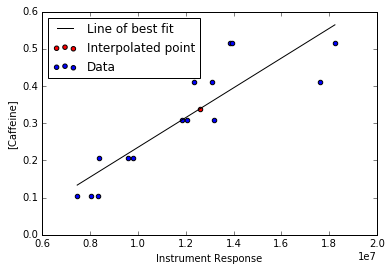

In [72]:
print "Analyzing Caffeine: "
Caffeine = LinReg(caf_response, caf_conc)
Caffeine.compute_model()
Caffeine.interpolate(caf_unknown)
Caffeine.calculate(MM_caf)
Caffeine.plot(xlabel='Instrument Response', ylabel='[Caffeine]')

Analyzing Acetominophen: 
Computing model...
******************************
Slope:  1.11014266837e-07
Offset:  -1.60486375561
R2: 0.941636299038



Interpolating...
*******************************
Interpolated value: 1.80980295855 +/- 0.0540253521603
95.0% confidence interval: [1.69308828109, 1.92651763601]



Calculating mass in pill...
*******************************
Mass in tablet: 0.275720932817g +/- 0.0178105987407g
95% CI: [0.257910334076, 0.293531531558]





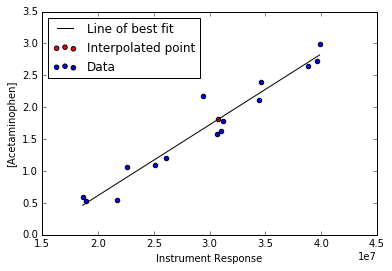

In [74]:
print "Analyzing Acetominophen: "
Ac = LinReg(ac_response, ac_conc)
Ac.compute_model()
Ac.interpolate(ac_unknown)
Ac.calculate(MM_ac)
Ac.plot(xlabel='Instrument Response', ylabel='[Acetaminophen]')

Analyzing Aspirin: 
Computing model...
******************************
Slope:  5.84576295207e-07
Offset:  -1.11706795729
R2: 0.95921267384



Interpolating...
*******************************
Interpolated value: 1.18758512573 +/- 0.0740040615032
95.0% confidence interval: [0.952071173619, 1.42309907783]



Calculating mass in pill...
*******************************
Mass in tablet: 0.21563102352g +/- 0.0427786752978g
95% CI: [0.172852348223, 0.258409698818]





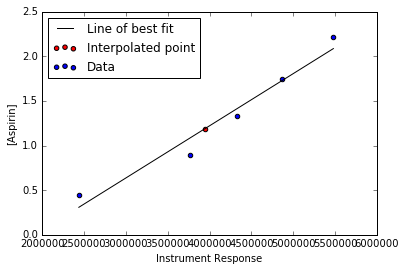

In [76]:
print "Analyzing Aspirin: "
AA = LinReg(aa_response, aa_conc)
AA.compute_model()
AA.interpolate(aa_unknown)
AA.calculate(MM_aa)
AA.plot(xlabel='Instrument Response', ylabel='[Aspirin]')